In this notebook, I will test methods to preprocess the images, such that they have similar intensity distributions. I will use 2 test images, and try to adjust one to the other.

# Example

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
img1_path = '../Data/chuv/p1'
img2_path = '../Data/pisa/p201'

img1 = np.load(os.path.join(img1_path, 'images.npy'))[5]
img2 = np.load(os.path.join(img2_path, 'images.npy'))[5]

mask1 = np.load(os.path.join(img1_path, 'labels.npy'))[5]
mask2 = np.load(os.path.join(img2_path, 'labels.npy'))[5]
mask1 = np.sum(mask1[...,[6,7,8]], axis=2)
mask2 = np.sum(mask2[...,[6,7,8]], axis=2)

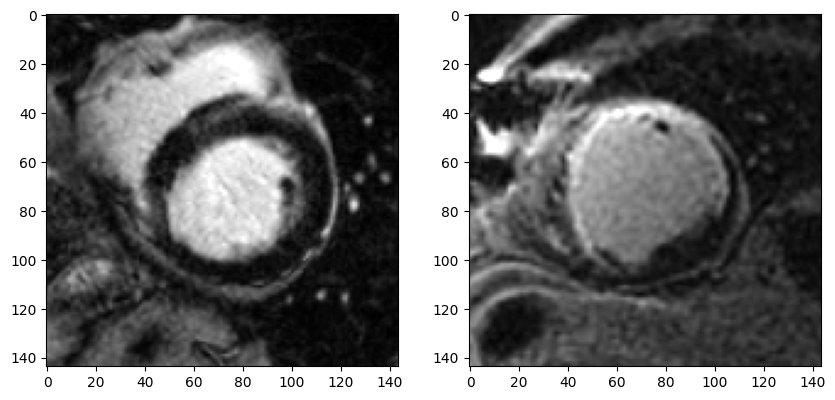

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

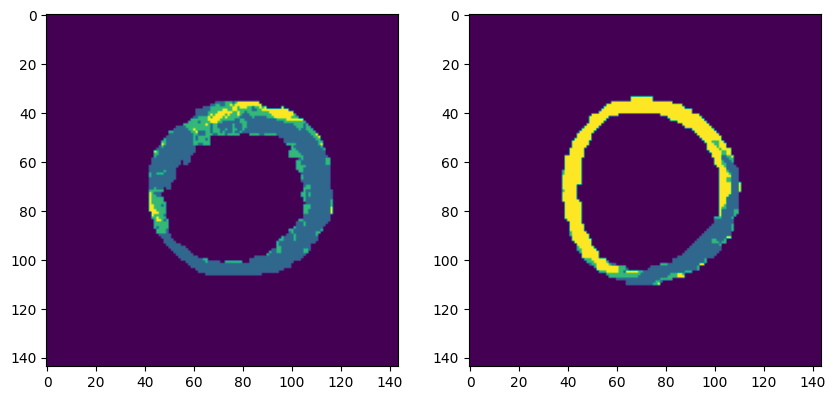

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(mask1)
ax[1].imshow(mask2)

### Intensity Distributions

In [9]:
sd5_pixels_1 = img1[mask1 == 3]
sd5_pixels_2 = img2[mask2 == 3]

sd2_pixels_1 = img1[mask1 == 2]
sd2_pixels_2 = img2[mask2 == 2]

myo_pixels_1 = img1[mask1 == 1]
myo_pixels_2 = img2[mask2 == 1]

background_pixels_1 = img1[mask1 == 0]
background_pixels_2 = img2[mask2 == 0]

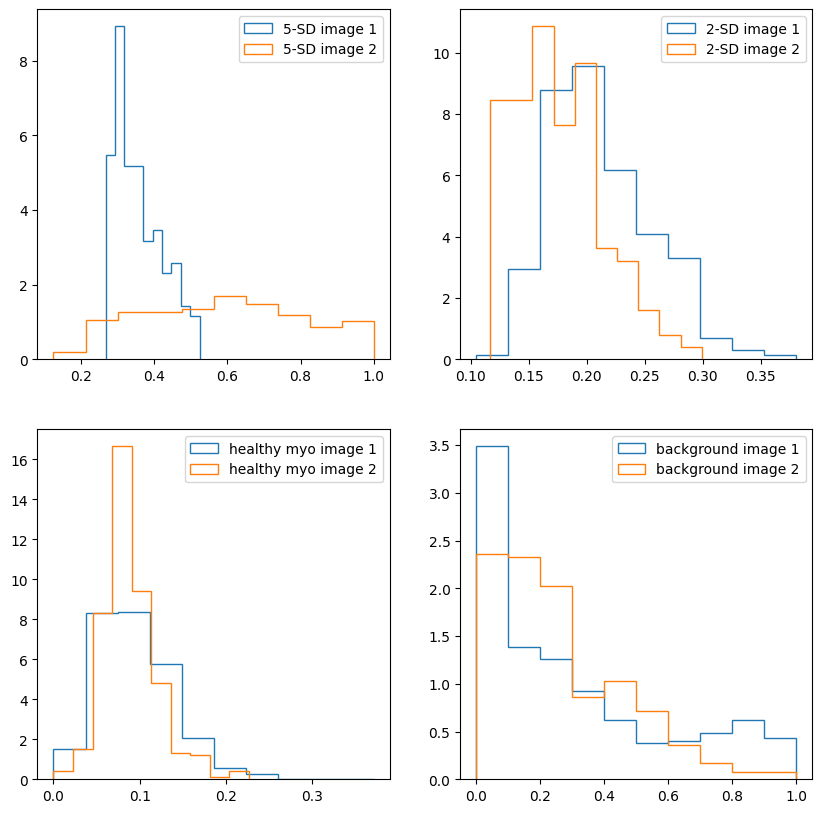

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(sd5_pixels_1, density=True, histtype='step', label='5-SD image 1')
ax[0,0].hist(sd5_pixels_2, density=True, histtype='step', label='5-SD image 2')
ax[0,0].legend()

ax[0,1].hist(sd2_pixels_1, density=True, histtype='step', label='2-SD image 1')
ax[0,1].hist(sd2_pixels_2, density=True, histtype='step', label='2-SD image 2')
ax[0,1].legend()

ax[1,0].hist(myo_pixels_1, density=True, histtype='step', label='healthy myo image 1')
ax[1,0].hist(myo_pixels_2, density=True, histtype='step', label='healthy myo image 2')
ax[1,0].legend()

ax[1,1].hist(background_pixels_1, density=True, histtype='step', label='background image 1')
ax[1,1].hist(background_pixels_2, density=True, histtype='step', label='background image 2')
ax[1,1].legend()

# Exploratory Analysis

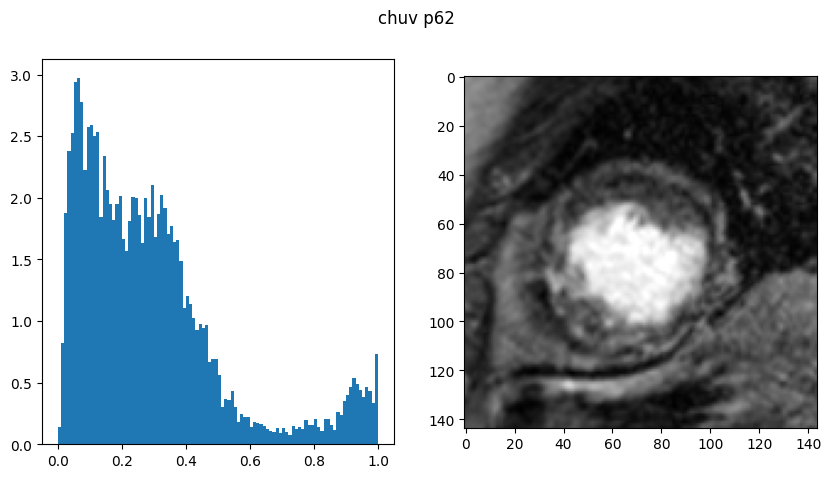

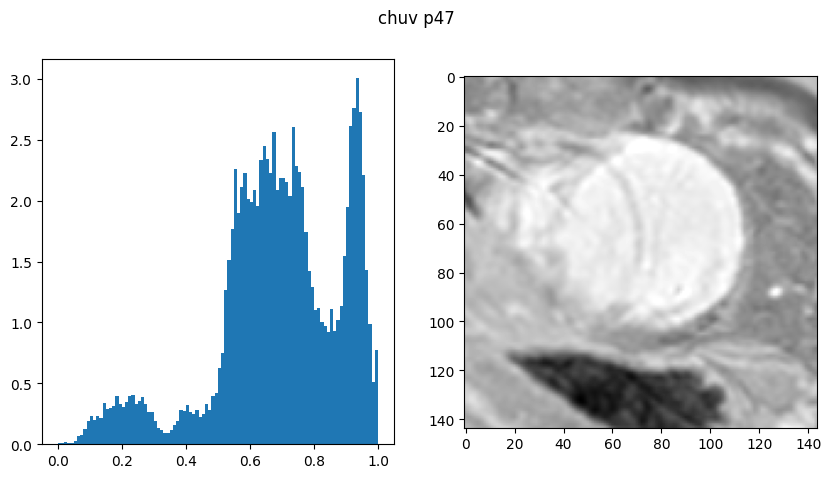

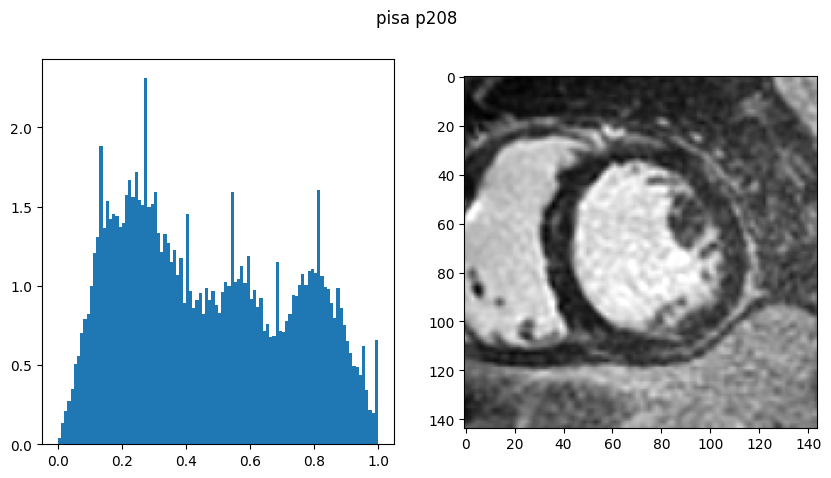

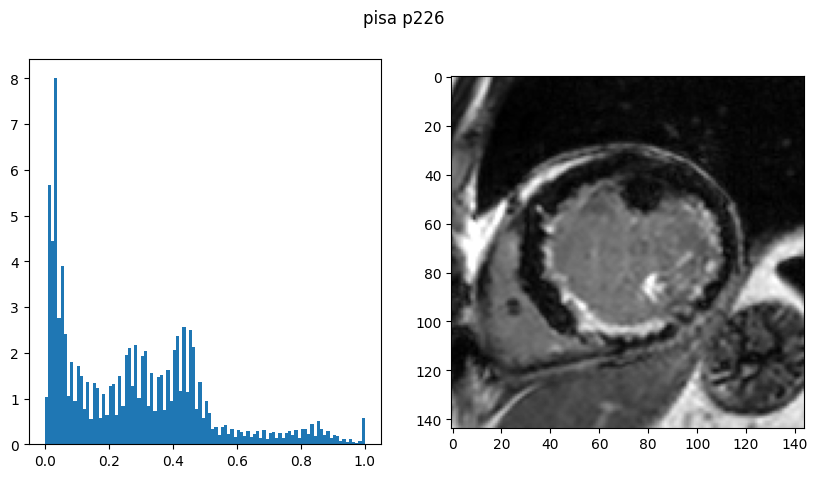

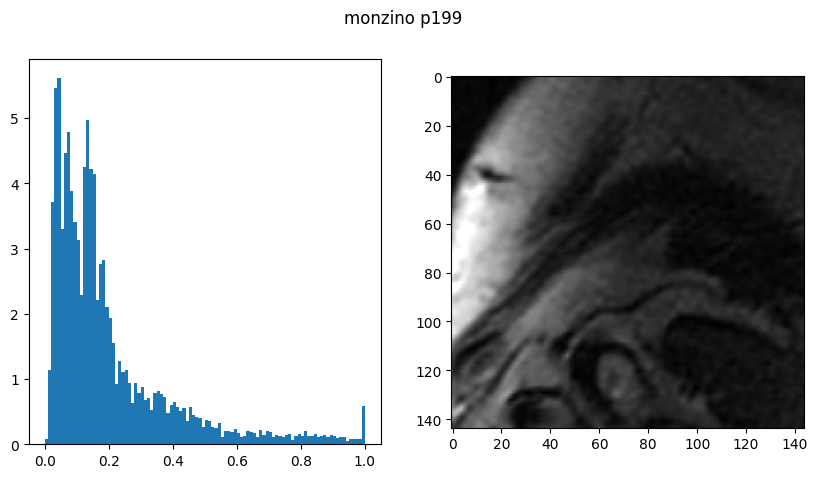

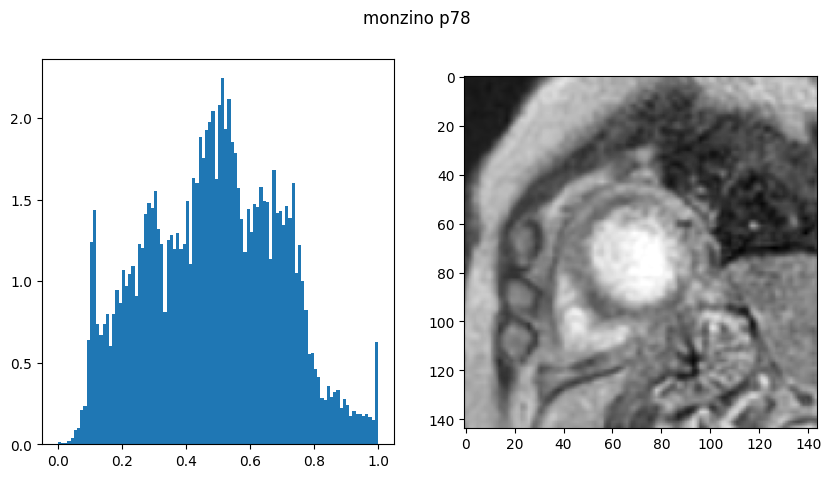

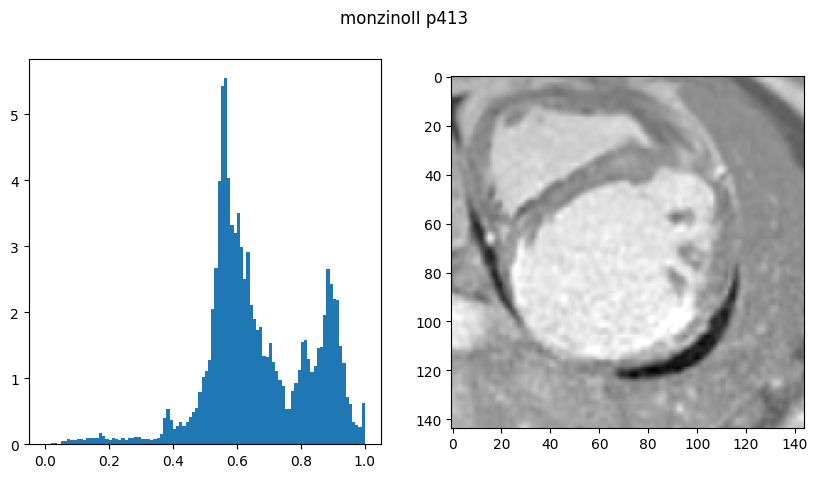

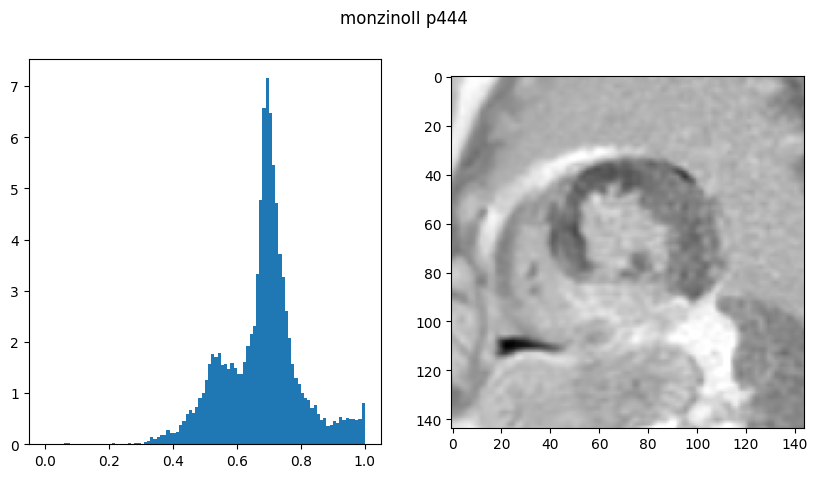

In [19]:
chuv_patients = os.listdir('../Data/chuv')
for p in chuv_patients[0:2]:
    img = np.load(os.path.join('../Data/chuv', p, 'images.npy'))[5]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    plt.suptitle('chuv '+ p)
    plt.show()
    
pisa_patients = os.listdir('../Data/pisa')
for p in pisa_patients[0:2]:
    img = np.load(os.path.join('../Data/pisa', p, 'images.npy'))[5]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    plt.suptitle('pisa ' + p)
    plt.show()
    
monzino_patients = os.listdir('../Data/monzino')
for p in monzino_patients[0:2]:
    img = np.load(os.path.join('../Data/monzino', p, 'images.npy'))[5]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    plt.suptitle('monzino ' + p)
    plt.show()
    
monzinoII_patients = os.listdir('../Data/monzinoII')
for p in monzinoII_patients[0:2]:
    img = np.load(os.path.join('../Data/monzinoII', p, 'images.npy'))[5]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    plt.suptitle('monzinoII ' + p)
    plt.show()

# Nyul Intensity Normalization

In [20]:
import nibabel as nib
from scipy.interpolate import interp1d

In [21]:
path = '../Data'
cohorts = ['chuv', 'pisa', 'monzino', 'monzinoII']
all_paths = []
for cohort in cohorts:
    for patient in os.listdir(os.path.join(path, cohort)):
        patient_path = os.path.join(path, cohort, patient)
        all_paths.append(patient_path)


In [22]:
len(all_paths)

305

In [46]:
def get_landmarks(img, percs):
    landmarks = np.percentile(img, percs)
    return landmarks


def nyul_train_standard_scale(img_fns,
                              mask_fns=None,
                              i_min=0,
                              i_max=100,
                              i_s_min=0,
                              i_s_max=1,
                              l_percentile=10,
                              u_percentile=90,
                              step=50):

    # compute masks is those are not entered as a parameters
    mask_fns = [None] * len(img_fns) if mask_fns is None else mask_fns

    percs = np.concatenate(([i_min],
                            np.arange(l_percentile, u_percentile+1, step),
                            [i_max]))

    standard_scale = np.zeros(len(percs))

    # process each image in order to build the standard scale
    for i, (img_fn, mask_fn) in enumerate(zip(img_fns, mask_fns)):
        print('processing scan ', img_fn)
        img_data = np.load(os.path.join(img_fn, 'images.npy'))
        landmarks = get_landmarks(img_data, percs)
        min_p = np.percentile(img_data, i_min)
        max_p = np.percentile(img_data, i_max)
        f = interp1d([min_p, max_p], [i_s_min, i_s_max])  # create interpolating function
        landmarks = np.array(f(landmarks)) # interpolate landmarks
        standard_scale += landmarks  # add landmark values of this volume to standard_scale

    standard_scale = standard_scale / len(img_fns)  # get mean values
    return standard_scale, percs
    
        
standard_scale, perc = nyul_train_standard_scale(all_paths)

processing scan  ../Data/chuv/p62
processing scan  ../Data/chuv/p47
processing scan  ../Data/chuv/p40
processing scan  ../Data/chuv/p37
processing scan  ../Data/chuv/p51
processing scan  ../Data/chuv/p71
processing scan  ../Data/chuv/p30
processing scan  ../Data/chuv/p15
processing scan  ../Data/chuv/p68
processing scan  ../Data/chuv/p22
processing scan  ../Data/chuv/p11
processing scan  ../Data/chuv/p56
processing scan  ../Data/chuv/p65
processing scan  ../Data/chuv/p66
processing scan  ../Data/chuv/p9
processing scan  ../Data/chuv/p45
processing scan  ../Data/chuv/p12
processing scan  ../Data/chuv/p8
processing scan  ../Data/chuv/p24
processing scan  ../Data/chuv/p4
processing scan  ../Data/chuv/p32
processing scan  ../Data/chuv/p69
processing scan  ../Data/chuv/p17
processing scan  ../Data/chuv/p14
processing scan  ../Data/chuv/p26
processing scan  ../Data/chuv/p43
processing scan  ../Data/chuv/p57
processing scan  ../Data/chuv/p36
processing scan  ../Data/chuv/p46
processing scan  

processing scan  ../Data/monzinoII/p394
processing scan  ../Data/monzinoII/p509
processing scan  ../Data/monzinoII/p357
processing scan  ../Data/monzinoII/p347
processing scan  ../Data/monzinoII/p345
processing scan  ../Data/monzinoII/p384
processing scan  ../Data/monzinoII/p447
processing scan  ../Data/monzinoII/p466
processing scan  ../Data/monzinoII/p316
processing scan  ../Data/monzinoII/p507
processing scan  ../Data/monzinoII/p495
processing scan  ../Data/monzinoII/p411
processing scan  ../Data/monzinoII/p458
processing scan  ../Data/monzinoII/p400
processing scan  ../Data/monzinoII/p391
processing scan  ../Data/monzinoII/p361
processing scan  ../Data/monzinoII/p501
processing scan  ../Data/monzinoII/p362
processing scan  ../Data/monzinoII/p392
processing scan  ../Data/monzinoII/p474
processing scan  ../Data/monzinoII/p370
processing scan  ../Data/monzinoII/p484
processing scan  ../Data/monzinoII/p471
processing scan  ../Data/monzinoII/p398
processing scan  ../Data/monzinoII/p448


In [47]:
standard_scale

array([0.        , 0.10031759, 0.35095392, 1.        ])

In [48]:
perc

array([  0,  10,  60, 100])

### Apply to images

In [49]:
i = 4
# examples: i=1, i=3
test_img = np.load(os.path.join(all_paths[i], 'images.npy'))[5]

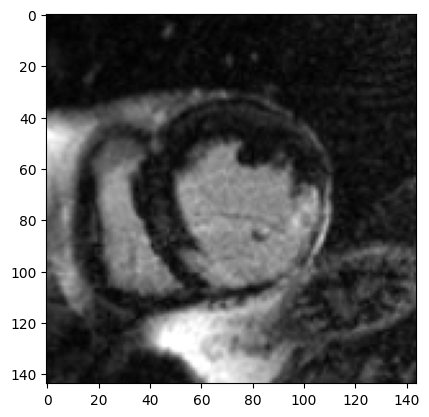

In [50]:
plt.imshow(test_img, cmap='gray')

In [51]:
def do_hist_normalization(input_image,
                          landmark_percs,
                          standard_scale,
                          mask=None,
                          interp_type='linear'):

    landmarks = get_landmarks(input_image, landmark_percs)
    f = interp1d(landmarks, standard_scale, kind=interp_type, fill_value='extrapolate')  # define interpolating function

    # apply transformation to input image
    return f(input_image)

test_img_norm = do_hist_normalization(test_img, perc, standard_scale)

Text(0.5, 1.0, 'normalized')

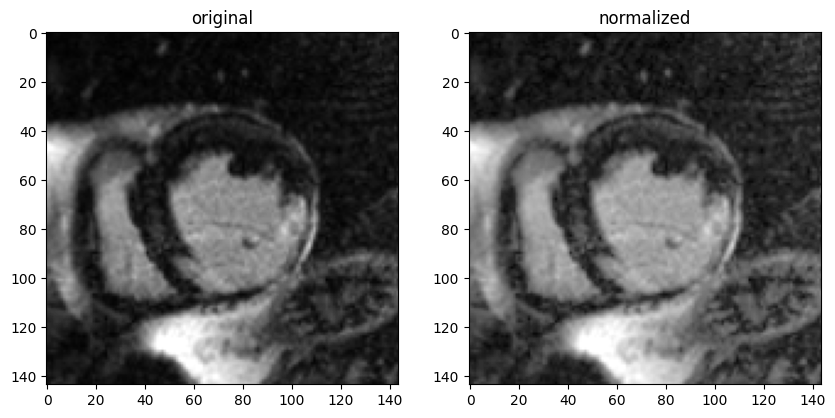

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(test_img, cmap='gray')
ax[0].set_title('original')
ax[1].imshow(test_img_norm, cmap='gray')
ax[1].set_title('normalized')

Text(0.5, 1.0, 'normalized')

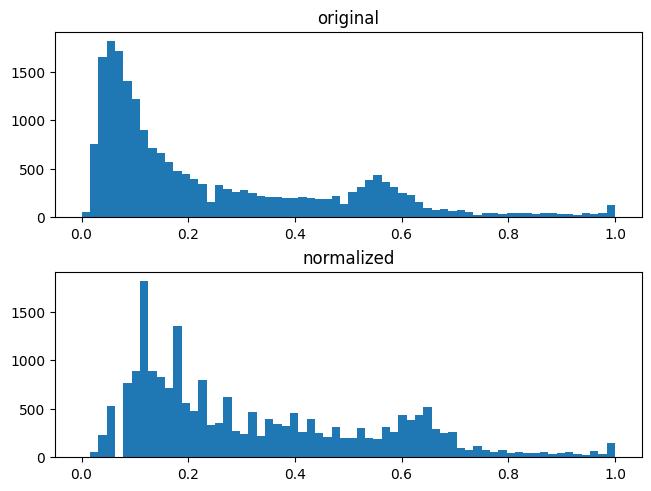

In [53]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
f1 = axs[0].hist(test_img.flatten(), bins=64, range=(0,1))
f2 = axs[1].hist(test_img_norm.flatten(), bins=64, range=(0,1))
axs[0].set_title('original')
axs[1].set_title('normalized')

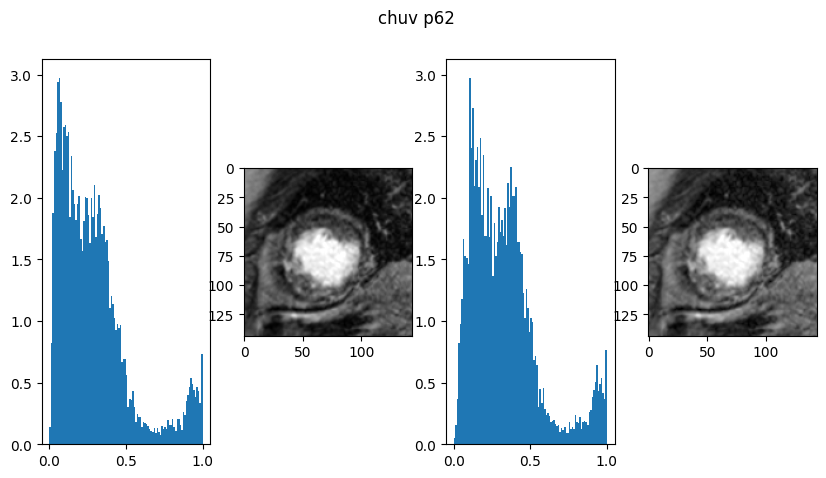

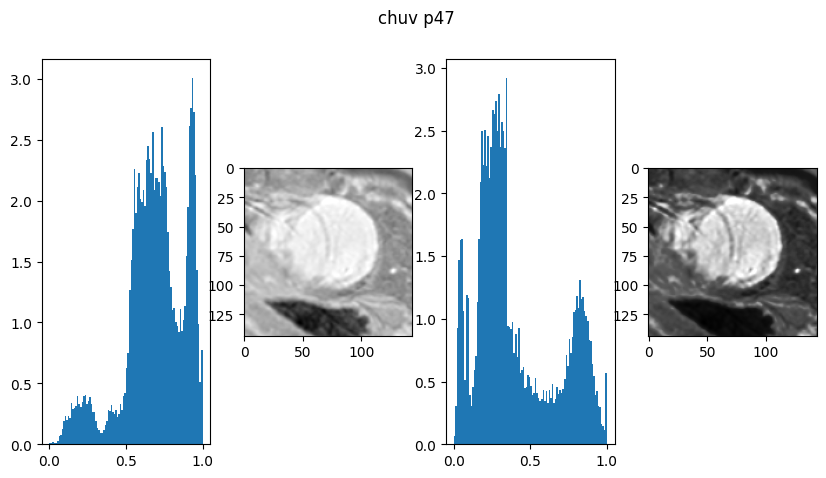

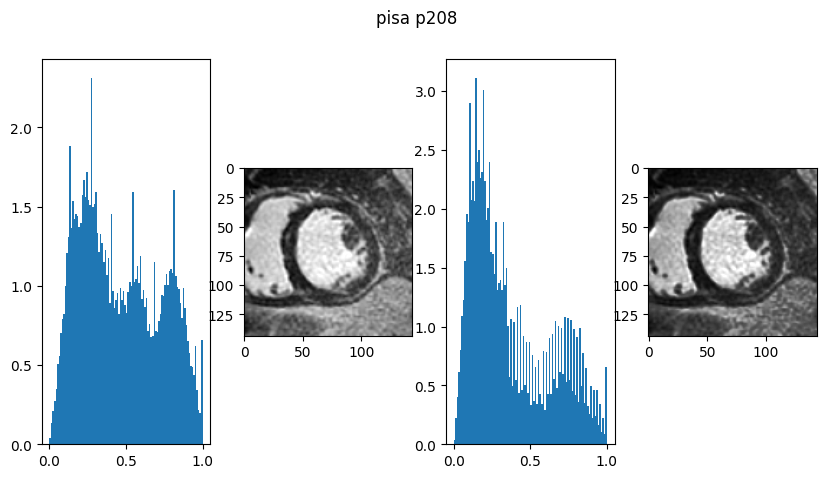

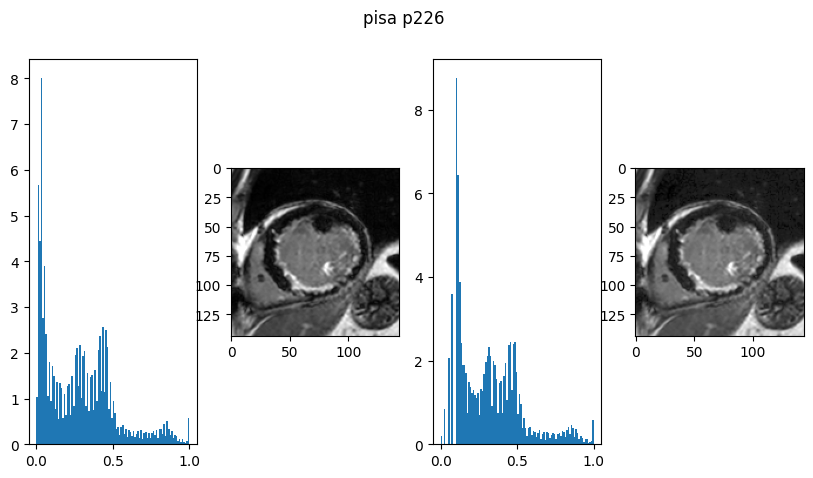

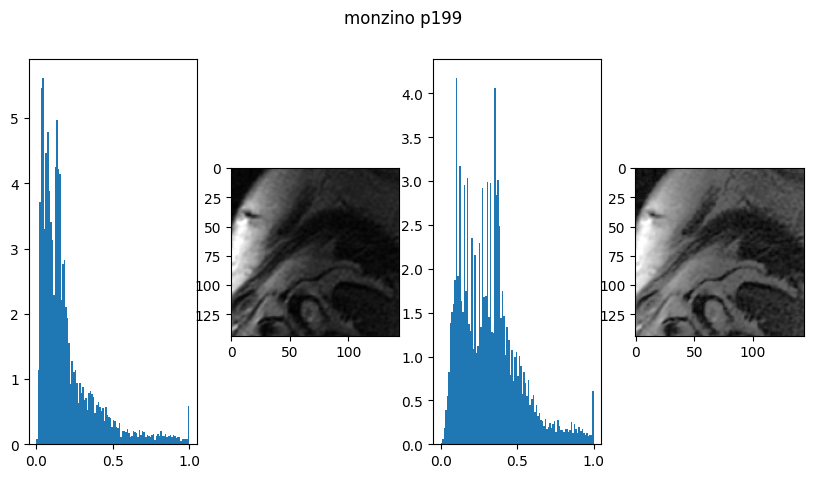

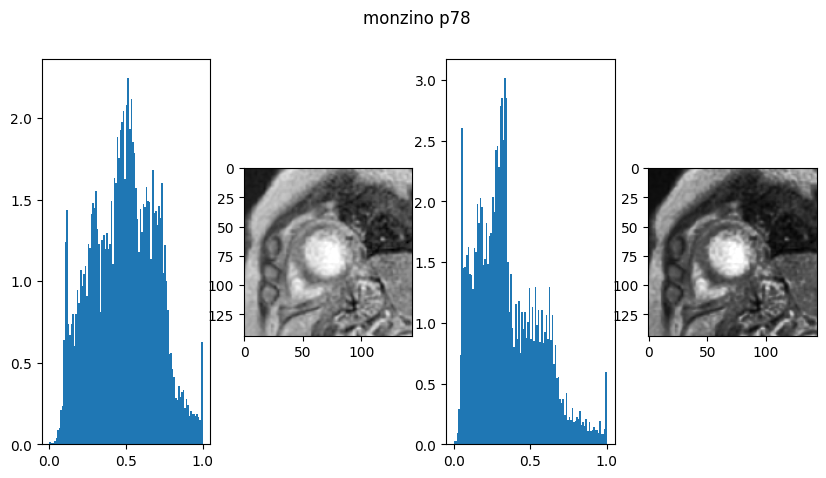

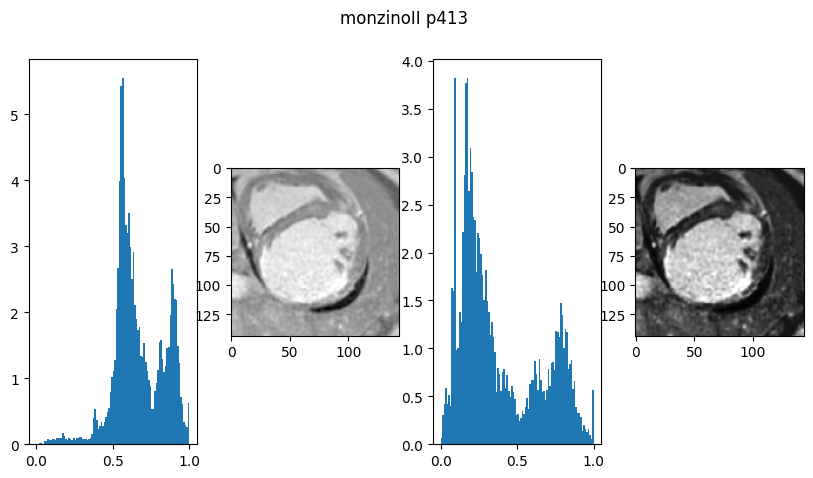

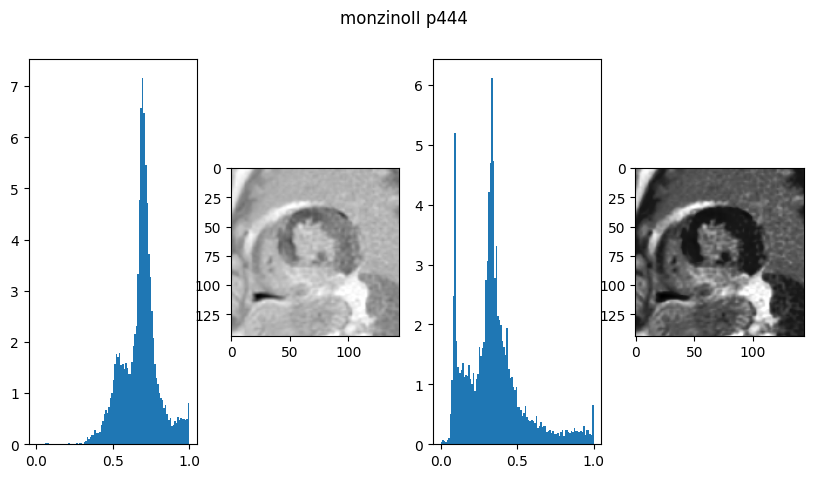

In [54]:
chuv_patients = os.listdir('../Data/chuv')
for p in chuv_patients[0:2]:
    img = np.load(os.path.join('../Data/chuv', p, 'images.npy'))[5]
    img_norm = do_hist_normalization(img, perc, standard_scale)
    fig, ax = plt.subplots(1,4, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    ax[2].hist(img_norm.flatten(), bins=100, density=True)
    ax[3].imshow(img_norm, cmap='gray')
    plt.suptitle('chuv '+ p)
    plt.show()
    
pisa_patients = os.listdir('../Data/pisa')
for p in pisa_patients[0:2]:
    img = np.load(os.path.join('../Data/pisa', p, 'images.npy'))[5]
    img_norm = do_hist_normalization(img, perc, standard_scale)
    fig, ax = plt.subplots(1,4, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    ax[2].hist(img_norm.flatten(), bins=100, density=True)
    ax[3].imshow(img_norm, cmap='gray')
    plt.suptitle('pisa ' + p)
    plt.show()
    
monzino_patients = os.listdir('../Data/monzino')
for p in monzino_patients[0:2]:
    img = np.load(os.path.join('../Data/monzino', p, 'images.npy'))[5]
    img_norm = do_hist_normalization(img, perc, standard_scale)
    fig, ax = plt.subplots(1,4, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    ax[2].hist(img_norm.flatten(), bins=100, density=True)
    ax[3].imshow(img_norm, cmap='gray')
    plt.suptitle('monzino ' + p)
    plt.show()
    
monzinoII_patients = os.listdir('../Data/monzinoII')
for p in monzinoII_patients[0:2]:
    img = np.load(os.path.join('../Data/monzinoII', p, 'images.npy'))[5]
    img_norm = do_hist_normalization(img, perc, standard_scale)
    fig, ax = plt.subplots(1,4, figsize=(10,5))
    ax[0].hist(img.flatten(), bins=100, density=True)
    ax[1].imshow(img, cmap='gray')
    ax[2].hist(img_norm.flatten(), bins=100, density=True)
    ax[3].imshow(img_norm, cmap='gray')
    plt.suptitle('monzinoII ' + p)
    plt.show()